<a href="https://colab.research.google.com/github/ck1972/University-GeoAI/blob/main/Lab_6a_Creating_AGBD_Training_Data_with_GEDI_and_Sentinel_2_for_Machine_Learning1_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 6a. Creating AGBD Training Data with GEDI and Sentinel-2 for Machine Learning**

## Introduction
In this tutorial, we prepare training data for modeling aboveground biomass density (AGBD). We use Google Earth Engine (API) for taining data prepation.
To run this script, the user must have an Earth Engine account and authenticate the Earth Engine Python API.

## Initialize and Authenticate Earth Engine
To get started with Google Earth Engine (GEE), you need to initialize and authenticate the Earth Engine API. Follow these steps.


First, import the Earth Engine API by importing the ee module into your Python environment. This module allows you to interact with the Earth Engine platform.


In [ ]:
# Import the API
import ee

Next, initialize the Earth Engine API.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-kamusoko-test') ## Change to your EE project

## Install and import libraries
Next, import the essential libraries needed to process and analyze the datasets.

In [ ]:
# Import the necessary libraries
import geemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Prepare predictor variables
This tutorial will use predictor variables such as Sentinel-2, the normalized difference vegetation index (NDVI), the soil-adjusted vegetation index (SAVI), the red edge spectral index (RESI), elevation, and slope.

In [ ]:
# Load the boundary
boundary = ee.FeatureCollection('projects/ee-kamusoko-test/assets/Mafungautsi_Project_Boundary') # You change to your boundary here

### Create Sentinel-2 composite
Next, load Sentinel-2 spectral reflectance data from the COPERNICUS 'S2_SR_HARMONIZED' image collection in Earth Engine. .


In [ ]:
# Load Sentinel-2 SR data
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Cloud masking function
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = ee.Number(2).pow(10).int()
    cirrus_bit_mask = ee.Number(2).pow(11).int()
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
        qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    # Scale only reflectance bands
    reflectance_bands = image.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12']).divide(10000)
    return reflectance_bands.updateMask(mask)

# Set time range
start_date = '2022-01-01'
end_date = '2022-04-30'

# Filter and prepare composite
composite = s2.filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(mask_s2_clouds) \
    .map(lambda img: img.clip(boundary))  # clip early to save memory

# Create median composite
S2_composite = composite.median()

### Compute spectral indices
Next, calculate NDVI, canopy chlorophyll content index (CCCI), and specific leaf area vegetation index (SLAVI) from the Sentinel-2 composite.

In [ ]:
# Spectral indices
def compute_ndvi(image):
    return image.addBands(image.select('B8').subtract(image.select('B4'))
                          .divide(image.select('B8').add(image.select('B4')))
                          .rename('NDVI'))

def compute_ccci(image):
    return image.addBands(image.select('B8').subtract(image.select('B5'))
                          .divide(image.select('B8').add(image.select('B5')))
                          .rename('CCCI'))

def compute_slavi(image):
    return image.addBands(image.select('B8')
                          .divide(image.select('B4').add(image.select('B11')))
                          .rename('SLAVI'))

# Apply indices
S2_composite = compute_ndvi(S2_composite)
S2_composite = compute_ccci(S2_composite)
S2_composite = compute_slavi(S2_composite)

# Extract layers
ndvi = S2_composite.select('NDVI')
ccci = S2_composite.select('CCCI')
slavi = S2_composite.select('SLAVI')

# Create map for visualization
Map = geemap.Map()
Map.centerObject(boundary, 12)

Map.addLayer(S2_composite, {'bands': ['B11', 'B8', 'B3'], 'min': 0, 'max': 0.3}, 'Sentinel-2 Composite')
Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI')
Map.addLayer(ccci, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'CCCI')
Map.addLayer(slavi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'SLAVI')

Map.addLayerControl()
Map

Map(center=[-18.428640932840132, 28.816360682021763], controls=(WidgetControl(options=['position', 'transparen…

### Merge all predictor variables


In [ ]:
# Function to cast image bands to Float32
def cast_to_float32(image):
    return image.toFloat()

# Cast all images to Float32
S2_composite = cast_to_float32(S2_composite)
ndvi = cast_to_float32(ndvi)
ccci = cast_to_float32(ccci)
slavi = cast_to_float32(slavi)

# Define the merged collection
mergedCollection = (
    S2_composite
    .addBands(ndvi)
    .addBands(ccci)
    .addBands(slavi)
)

# Clip the output image to the farm boundary
clippedmergedCollection = mergedCollection.clipToCollection(boundary)

## Prepare the response variable
### Filtering and preparing GEDI Level 4A data
Derive aboveground biomass density (AGBD) from the GEDI Level 4A (L4A) dataset. This dataset contains AGBD predictions in Mg/ha. More information about this dataset is available at: https://developers.google.com/earth-engine/datasets/catalog/LARSE_GEDI_GEDI04_A_002.


In [ ]:
# Select a time-period
start_date = ee.Date.fromYMD(2022, 1, 1)
end_date = ee.Date.fromYMD(2022, 5, 30)

# Load the GEDI Level 4A dataset
gedi = ee.ImageCollection('LARSE/GEDI/GEDI04_A_002_MONTHLY')

# Function to select highest quality GEDI data
def quality_mask(image):
    return image.updateMask(image.select('l4_quality_flag').eq(1)) \
                .updateMask(image.select('degrade_flag').eq(0))

# Function to mask unreliable GEDI measurements with a relative standard error > 50%
def error_mask(image):
    relative_se = image.select('agbd_se').divide(image.select('agbd'))
    return image.updateMask(relative_se.lte(0.5))

# Function to mask GEDI measurements on slopes > 30%
def slope_mask(image):
    # Load the SRTM digital elevation model
    srtm = ee.Image('USGS/SRTMGL1_003')

    # Calculate slope
    slope = ee.Terrain.slope(srtm)

    return image.updateMask(slope.lt(30))

# Apply the filters
gedi_filtered = gedi.filter(ee.Filter.date(start_date, end_date)) \
                    .filter(ee.Filter.bounds(boundary))

gedi_projection = ee.Image(gedi_filtered.first()).select('agbd').projection()

gedi_processed = gedi_filtered.map(quality_mask).map(error_mask).map(slope_mask)

# Create a mosaic of the filtered images
gedi_mosaic = gedi_processed.mosaic().select('agbd').setDefaultProjection(gedi_projection).clip(boundary)

# Create the display parameters
gediVis = {
    'min': 1,
    'max': 300,
    'palette': 'red, green, blue',
}

### Sampling points and calculating key AGBD metrics

In [ ]:
# Sample the training points (ta) from the dataset
points = gedi_mosaic.sample(
    region=boundary,
    scale=30,
    geometries=True
)

# Get the AGDB values from the 'agbd' property of the filtered points
agbd_values = points.aggregate_array('agbd').getInfo()

# Calculate summary statistics
mean_agbd = np.mean(agbd_values)
median_agbd = np.median(agbd_values)
std_agbd = np.std(agbd_values)
min_agbd = np.min(agbd_values)
max_agbd = np.max(agbd_values)

# Print the summary statistics
print("Mean AGBD:", mean_agbd)
print("Median AGBD:", median_agbd)
print("Standard Deviation AGBD:", std_agbd)
print("Minimum AGBD:", min_agbd)
print("Maximum AGBD:", max_agbd)

# Print and display the training (ta) points derived from the GEDI L4B dataset
print(points.size().getInfo())
print(points.first().getInfo())

Mean AGBD: 44.93472965600906
Median AGBD: 43.82386602929688
Standard Deviation AGBD: 28.64601910578379
Minimum AGBD: 6.005444049835205
Maximum AGBD: 271.40979
6184
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [29.084257624532196, -18.565442565314093]}, 'id': '0', 'properties': {'agbd': 47.31719970703125}}


### Display GEDI Level 4A AGBD
Next, display GEDI AGBD sample points.

In [ ]:
# Display the GEDI L4A mean above-ground biomass (AGB) points and the derived training points
# Initialize the map
map4 = geemap.Map()
map4.centerObject(boundary, 12)
map4.addLayer(gedi_mosaic, gediVis, 'GEDI L4A Mean AGBD points')
map4.addLayer(points, {'color': '808080'}, 'Mean AGBD training points')

# Display the map
display(map4)

The provided color (red, green, blue) is invalid. Using the default black color.
'#red, green, blue' is not in web format. Need 3 or 6 hex digit.


Map(center=[-18.428640932840132, 28.816360682021763], controls=(WidgetControl(options=['position', 'transparen…

Next, create density and box plots for the GEDI L4A datasets using the seaborn library for density plots and matplotlib for box plots.

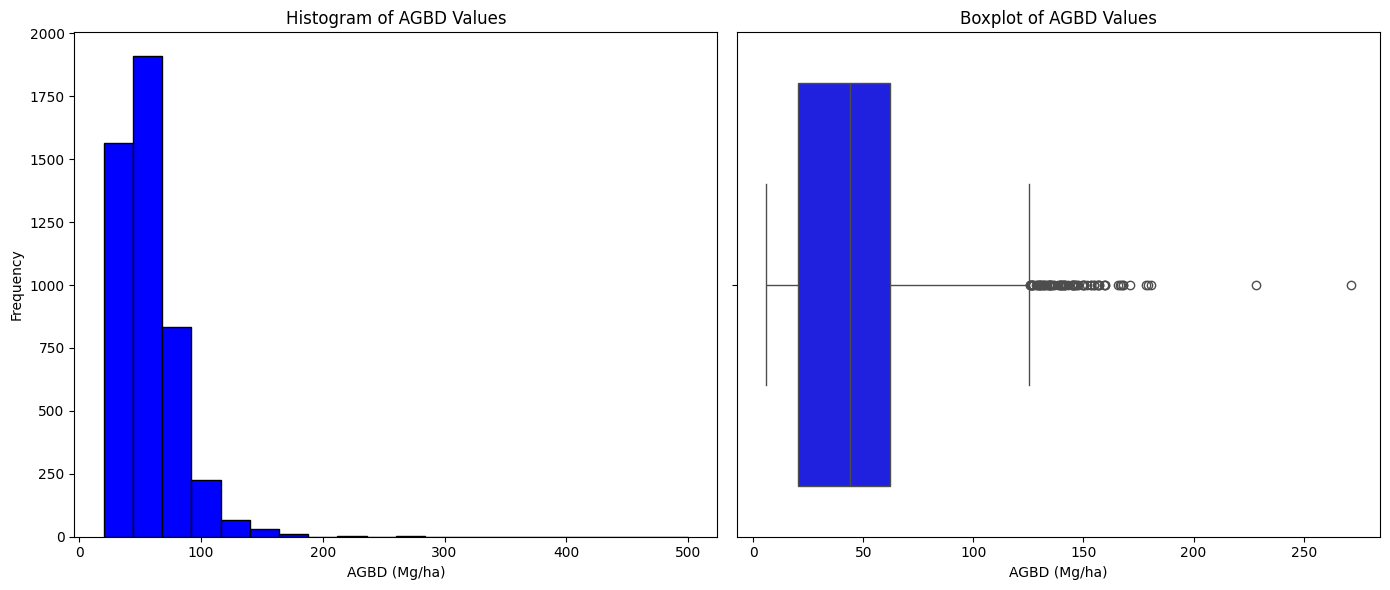

In [ ]:
# Create a figure with 1 row and 2 columns
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(agbd_values, bins=20, range=[20, 500], color='blue', edgecolor='black')
plt.xlabel('AGBD (Mg/ha)')
plt.ylabel('Frequency')
plt.title('Histogram of AGBD Values')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=agbd_values, color='blue')
plt.xlabel('AGBD (Mg/ha)')
plt.title('Boxplot of AGBD Values')

# Display both plots
plt.tight_layout()
plt.show()

### Data cleaning

Next, we will filter the data points to retain aboveground biomass density (AGBD) values within 0 to 130 megagrams per hectare (Mg/ha).

In [ ]:
# Filter the training points by range (0 Mg/ha to 130 Mg/ha)
filteredPoints = points.filter(
    ee.Filter.And(
        ee.Filter.gte('agbd', 0),
        ee.Filter.lte('agbd', 130)
    )
)

# Print and display the training (ta) points derived from the GEDI L4B dataset
print(filteredPoints.size().getInfo())
print(filteredPoints.first().getInfo())

# Display the GEDI L4A mean above-ground biomass (AGB) points and the derived training points
# Initialize the map
map5 = geemap.Map()
map5.centerObject(boundary, 12)
map5.addLayer(filteredPoints, {'color': '808080'}, 'Mean fitered AGBD training points')
# Display the map
display(map5)

6118
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [29.084257624532196, -18.565442565314093]}, 'id': '0', 'properties': {'agbd': 47.31719970703125}}


Map(center=[-18.428640932840132, 28.816360682021763], controls=(WidgetControl(options=['position', 'transparen…

Mean AGBD: 43.7983608865895
Median AGBD: 43.541641017211916
Standard Deviation AGBD: 26.517626031002173
Minimum AGBD: 6.005444049835205
Maximum AGBD: 129.661942
6184
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [29.084257624532196, -18.565442565314093]}, 'id': '0', 'properties': {'agbd': 47.31719970703125}}


<Figure size 1400x600 with 0 Axes>

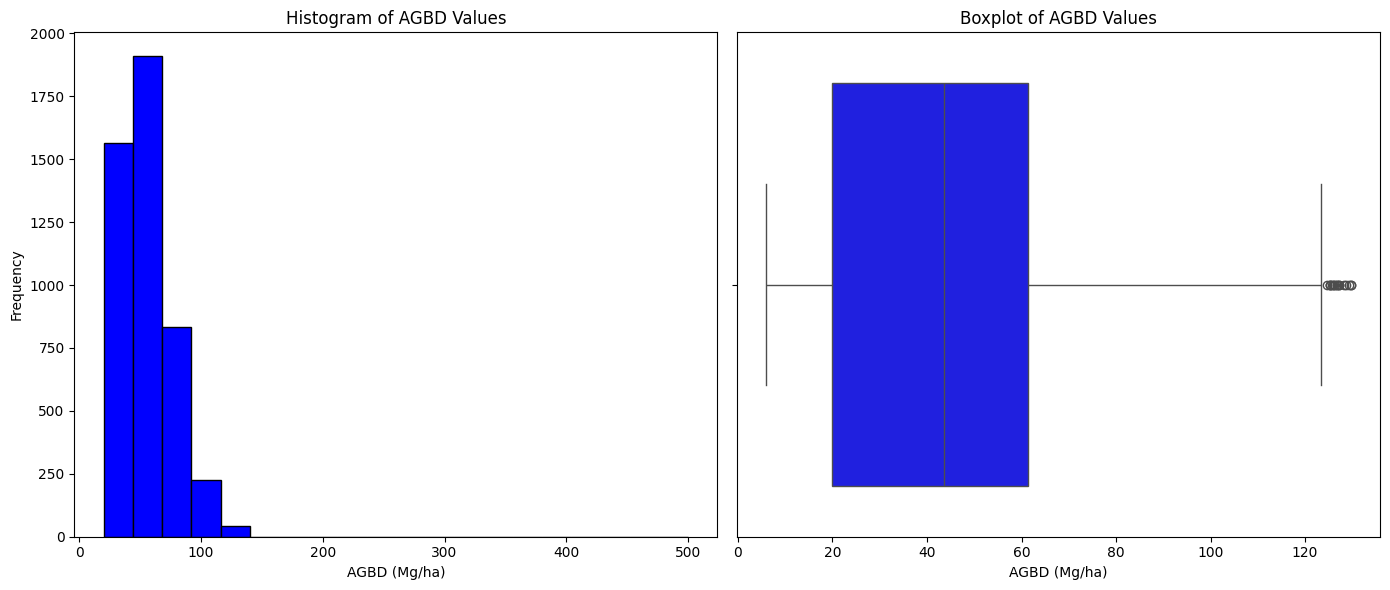

In [ ]:
# Get the AGDB values from the 'agbd' property of the filtered points
agbd_values = filteredPoints.aggregate_array('agbd').getInfo()

# Calculate summary statistics
mean_agbd = np.mean(agbd_values)
median_agbd = np.median(agbd_values)
std_agbd = np.std(agbd_values)
min_agbd = np.min(agbd_values)
max_agbd = np.max(agbd_values)

# Print the summary statistics
print("Mean AGBD:", mean_agbd)
print("Median AGBD:", median_agbd)
print("Standard Deviation AGBD:", std_agbd)
print("Minimum AGBD:", min_agbd)
print("Maximum AGBD:", max_agbd)

# Print and display the training (ta) points derived from the GEDI L4B dataset
print(points.size().getInfo())
print(points.first().getInfo())

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(14, 6))

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(agbd_values, bins=20, range=[20, 500], color='blue', edgecolor='black')
plt.xlabel('AGBD (Mg/ha)')
plt.ylabel('Frequency')
plt.title('Histogram of AGBD Values')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=agbd_values, color='blue')
plt.xlabel('AGBD (Mg/ha)')
plt.title('Boxplot of AGBD Values')

# Display both plots
plt.tight_layout()
plt.show()

## Sampling training data in Google Earth Engine
We will select specific bands from the 'clippedmergedCollection' and then sample the values (spectral reflectance values) at the locations of the 'trainingData' points.


In [ ]:
# Select specific bands or variables from the 'clippedmergedCollection'
predictor_vars = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'NDVI', 'CCCI', 'SLAVI']
# Sample the values at the locations of the 'trainingData' points.
trainingData = clippedmergedCollection.select(predictor_vars).sampleRegions(**{
    'collection': filteredPoints,  # The 'trainingData' is the FeatureCollection containing training points.
    'properties': ['agbd'],  # The property 'agbd' is used as the label for the training points.
    'scale': 50  # The scale (resolution) at which the sampling is performed (in meters).
})

## Export imagery and training data to Google Drive
Next, we will export the imagery and training data to your Google Drive since we want to use machine learning algorithms available in Scikit Learn.

In [ ]:
# Export the training data to Google Drive
task = ee.batch.Export.image.toDrive(**{
    'image': clippedmergedCollection,
    'description': 'S2_predictors_2022',
    'folder': 'Maf_datasets',
    'fileNamePrefix': 'S2_predictors_2022',
    'region': boundary.geometry().bounds().getInfo()['coordinates'],
    'scale': 20,
    'fileFormat': 'GeoTIFF'
})

task.start()

# Export the training data to Google Drive
task = ee.batch.Export.table.toDrive(**{
    'collection': trainingData,
    'description': 'Small_GEDI_L4A_2022_Dataset1',
    'folder': 'Maf_datasets',
    'fileFormat': 'CSV'
})

task.start()

print("Exporting the training data to Google Drive. This may take a while...")